In [ ]:
dataframe <- read.csv(file = "../donnees_meteo_synop.csv", header = TRUE, sep = ";")

In [3]:
head(dataframe)

,ID.OMM.station,Date,Pression.au.niveau.mer,Variation.de.pression.en.3.heures,Type.de.tendance.barométrique,Direction.du.vent.moyen.10.mn,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,⋯,Altitude,communes..name.,communes..code.,EPCI..name.,EPCI..code.,department..name.,department..code.,region..name.,region..code.,mois_de_l_annee
,<int>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,7181,2016-07-12T11:00:00+02:00,101410,-30,8,230,2.9,293.35,286.55,65,⋯,336,Thuilley-aux-Groseilles,54523,CC du Pays de Colombey et du Sud Toulois,245400510,Meurthe-et-Moselle,54,Grand Est,44,7
2,81405,2017-01-08T07:00:00+01:00,101140,-140,8,240,0.5,297.25,296.25,94,⋯,4,Matoury,97307,CA du Centre Littoral,249730045,Guyane,973,Guyane,3,1
3,7627,2017-01-08T13:00:00+01:00,103380,-40,8,30,2.1,277.55,269.75,57,⋯,414,Lorp-Sentaraille,09289,CC Couserans-Pyrénées,200067940,Ariège,09,Occitanie,76,1
4,78894,2017-01-09T13:00:00+01:00,101760,0,NA,100,2.3,298.15,291.35,66,⋯,44,,,,NA,,,,NA,1
5,7020,2017-01-12T13:00:00+01:00,100580,-710,8,210,11.9,282.05,280.15,88,⋯,6,La Hague,50041,CA du Cotentin,200067205,Manche,50,Normandie,28,1
6,7280,2017-12-23T13:00:00+01:00,103830,-10,0,10,2.7,280.75,278.35,85,⋯,219,Ouges,21473,Dijon Métropole,242100410,Côte-d'Or,21,Bourgogne-Franche-Comté,27,12


# ACP et PLS

On essaye de toujours garder en tête : 
1) Quelle question je me pose sur les données ? Qu'est ce que je veux illustrer ? 
2) Pourquoi la méthode que je vais utiliser est pertinente ? 
3) Quelles conclusions j'en retire ? 
4) Quelles sont les possible limitation de ce que je propose ?

## 1. ACP

Pour faire une analyse en composantes principales (ACP), on utilise la fonctio `prcomp()` et on stocke le résultat retourné dans un objet sur notre espace de travail.

`prcomp()` ne gère pas les NA : il faut alors netoyer les données avant de l'utiliser. On retire aussi les colonnes non numériques.

De plus, notre jeu de données étant très lourd, on doit optimiser la mémoire utilisée pour ne pas faire crasher notre kernel. La fonction `prcomp_irlba()` du package `irlba` permet de faire une ACP tronquée, c'est à dire qu'on ne calcule que les premières composantes principales. C'est souvent suffisant pour avoir une bonne idée de la structure des données.

```r



In [7]:
library(data.table)

# Sélection des colonnes numériques :
num_cols <- names(dataframe)[sapply(dataframe, is.numeric)]
X <- dataframe[, num_cols]

cat("Numériques initiales :", length(num_cols), "\n")
cat("Taille objet X :", format(object.size(X), units="MB"), "\n")

# Sélection des colonnes sans NA (seuil 40%)
keep_na <- colMeans(is.na(X)) < 0.40
X <- X[, keep_na]
cat("Après filtre NA (<40%) :", ncol(X), "colonnes\n")

# Sélection des colonnes à variance positive
v_sd <- sapply(X, function(v) sd(v, na.rm=TRUE))
X <- X[, v_sd > 0]
cat("Après filtre variance :", ncol(X), "colonnes\n")

# Échantillonnage à cause de la taille de notre fichier de données
if (nrow(X) > 80000) {
  set.seed(42)
  sel <- sample(nrow(X), 80000)
  X <- X[sel, ]
  cat("Échantillon: 80000 lignes\n")
}

# 5. Imputation simple (médiane) au lieu de complete.cases pour éviter pertes massives + copies
for (j in seq_len(ncol(X))) {
  if (anyNA(X[,j])) {
    med <- suppressWarnings(median(X[,j], na.rm=TRUE))
    if (is.finite(med)) X[is.na(X[,j]), j] <- med
  }
}
cat("NA restants après imputation :", sum(is.na(X)), "\n")

cat("Taille objet avant PCA :", format(object.size(X), units="MB"), "\n")

# Conversion en matrice 
Xm <- as.matrix(X)

# ACP tronquée 
if (!requireNamespace("irlba", quietly=TRUE)) install.packages("irlba")
library(irlba)
k <- min(20, ncol(Xm) - 1)  # nombre de composantes souhaitées
pc_irlba <- prcomp_irlba(scale(Xm, center=TRUE, scale=TRUE), n = k)
cat("Composantes calculées (irlba):", k, "\n")

# Variance expliquée
var_exp <- pc_irlba$sdev^2 / sum(pc_irlba$sdev^2)
print(round(var_exp[1:10] * 100, 2))


Numériques initiales : 64 
Taille objet X : 688.8 Mb 
Après filtre NA (<40%) : 31 colonnes
Après filtre variance : 31 colonnes
Échantillon: 80000 lignes
NA restants après imputation : 0 
Taille objet avant PCA : 16.5 Mb 


Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.3.3”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


Composantes calculées (irlba): 20 
 [1] 15.47 12.91 11.37  7.87  6.06  5.79  5.25  4.77  3.66  3.41


In [8]:
# Quelques vérifications
cat("Classe de l'objet :", class(pc_irlba), "\n")
cat("Type de l'objet :", mode(pc_irlba), "\n")
cat("Test du type 'list' :", is.list(pc_irlba), "\n")

Classe de l'objet : irlba_prcomp prcomp 
Type de l'objet : list 
Test du type 'list' : TRUE 


La fonction `summary()` permet d'avoir un résumé de l'ACP avec notamment des informations sur chaque composante principale (comme on a utilisé une  ACP tronquée, on n'a pas la même sortie que pour une ACP classique, seulement 20 composantes sont calculées).

In [4]:
summary(pc_irlba)

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     2.1405 1.9559 1.8356 1.5269 1.34004 1.30941 1.24670
Proportion of Variance 0.1478 0.1234 0.1087 0.0752 0.05793 0.05531 0.05014
Cumulative Proportion  0.1478 0.2712 0.3799 0.4551 0.51301 0.56832 0.61846
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.18906 1.04114 1.00555 0.97154 0.94567 0.90843 0.88426
Proportion of Variance 0.04561 0.03497 0.03262 0.03045 0.02885 0.02662 0.02522
Cumulative Proportion  0.66407 0.69904 0.73165 0.76210 0.79095 0.81757 0.84279
                          PC15    PC16    PC17    PC18    PC19    PC20
Standard deviation     0.86089 0.81013 0.79513 0.75679 0.69647 0.63825
Proportion of Variance 0.02391 0.02117 0.02039 0.01848 0.01565 0.01314
Cumulative Proportion  0.86670 0.88787 0.90827 0.92674 0.94239 0.95553

**L'éboulis des valeurs propres** permet de visualiser la variance expliquée par chaque composante principale :

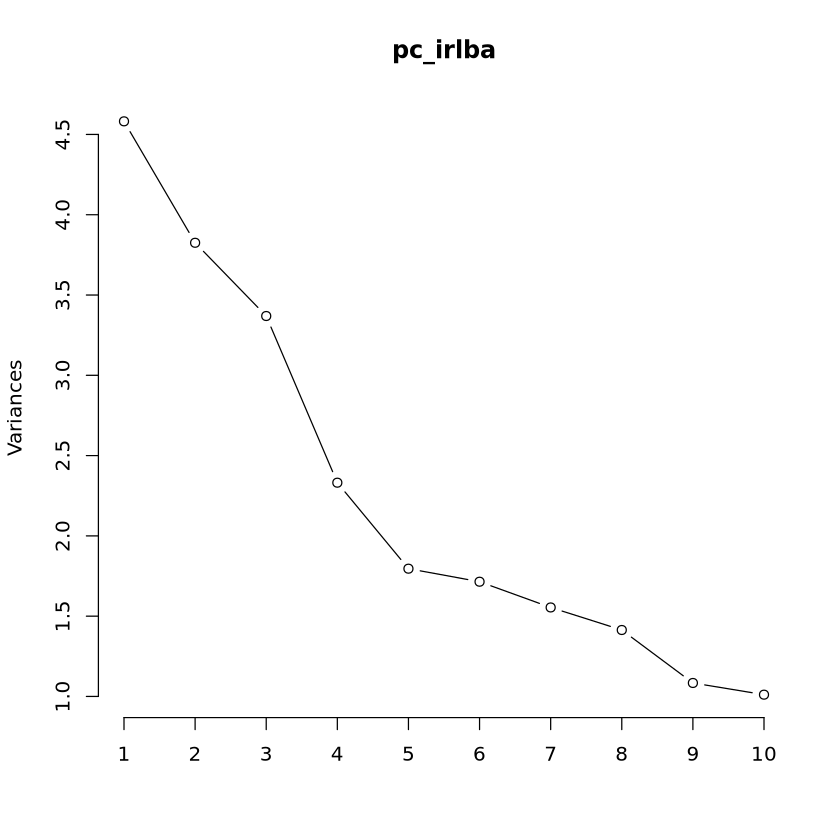

In [9]:
plot(pc_irlba, type="l")


Pour déterminer le nombre de variables raisonnable de retenir à partir de l'éboulis, on utilise la **règle du coude** : on regarde où l'éboulis commence à se stabiliser. Ici, on remarque que la pente de la courbe change à partir de la 5ème composante principale. On peut donc retenir les 4 premières composantes principales.

On trace ensuite les **biplots**. On a retenu 4 composantes principales. Chaque biplot est un plan 2D formé par une paire de composantes. Comme un biplot ne peut montrer que 2 axes à la fois, on explore plusieurs plans pour utiliser nos 4 composantes choisies. On trace donc les plans PC1-PC2, PC1-PC3, PC2-PC3 et PC3-PC4.


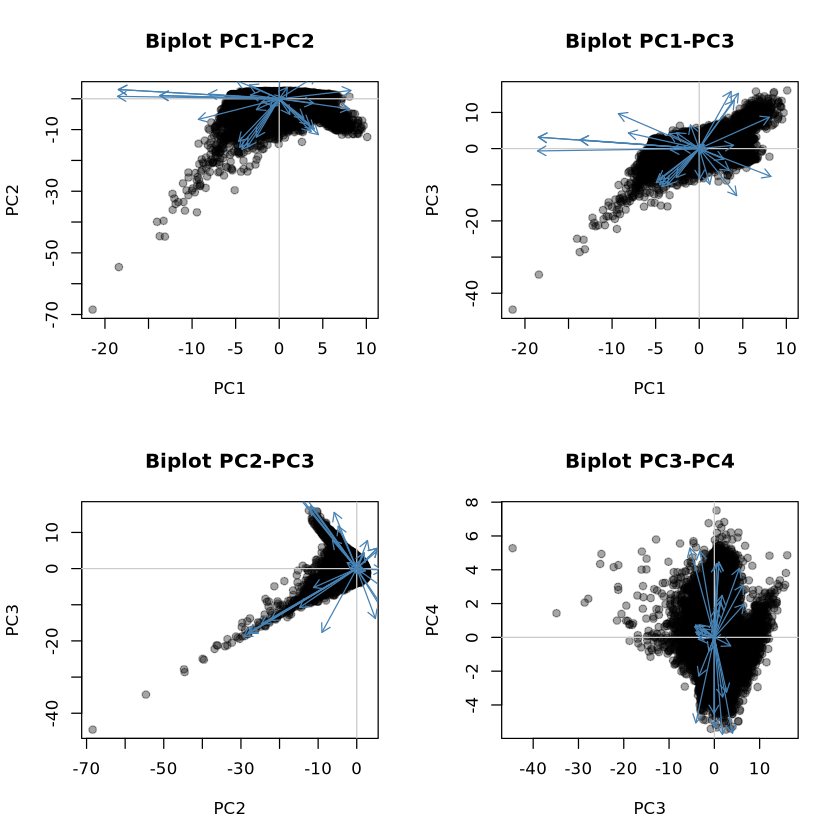

In [14]:
# --- Biplots pour les 4 composantes retenues ---

# Fonction biplot simple (base R) pour objet prcomp/prcomp_irlba
biplot_pc <- function(pca, axes = c(1,2), scale_arrows = 0.85, col_points = rgb(0,0,0,0.35)) {
  sc <- pca$x[, axes]
  ld <- pca$rotation[, axes]
  # Mise à l'échelle des flèches
  rng_sc <- apply(sc, 2, range)
  rng_ld <- apply(ld, 2, range)
  mult <- min( (diff(rng_sc[,1]) / diff(rng_ld[,1])),
               (diff(rng_sc[,2]) / diff(rng_ld[,2])) ) * scale_arrows
  ld2 <- ld * mult
  plot(sc,
       xlab = paste0("PC", axes[1]),
       ylab = paste0("PC", axes[2]),
       main = paste0("Biplot PC", axes[1], "-PC", axes[2]),
       pch = 19, col = col_points)
  abline(h=0,v=0,col="gray80")
  arrows(0,0, ld2[,1], ld2[,2], length=0.08, col="steelblue")
  text(ld2[,1], ld2[,2], labels = rownames(ld), col="steelblue4", cex=0.7, pos=3)
}

# Paires de plans à afficher
plans <- list(c(1,2), c(1,3), c(2,3), c(3,4))

op <- par(mfrow=c(2,2))
for (ax in plans) biplot_pc(pc_irlba, axes = ax)
par(op)


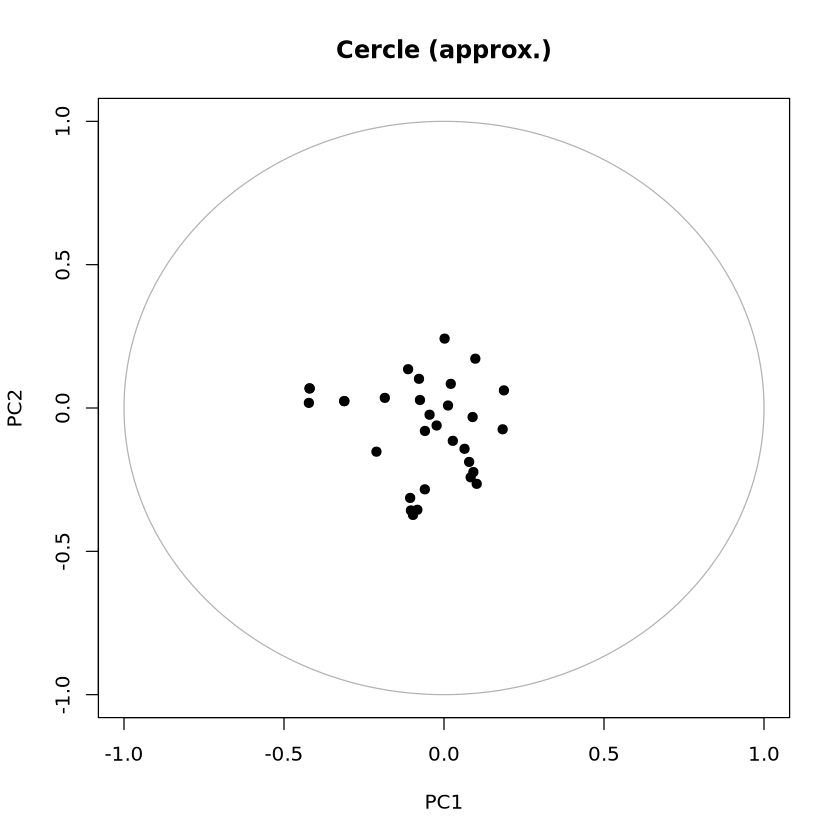

In [11]:
# Cercle corrélations 
rot <- pc_irlba$rotation[,1:2]
plot(rot, xlim=c(-1,1), ylim=c(-1,1), pch=19,
     xlab="PC1", ylab="PC2", main="Cercle (approx.)")
ang <- seq(0, 2*pi, length=300)
lines(cos(ang), sin(ang), col="gray70")
text(rot, labels=rownames(rot), cex=0.7, pos=3)

Une autre méthode pour faire une ACP serait de prendre un échantillon représentatif de nos données mais plus petit que le jeu initial et d'utiliser `prcomp()` classique. 

Pour des données météo, on peut sélectionner pour chaque station une donnée par mois ou par semaine par exemple (en faisant une moyenne) pour diminuer la taille du jeu de données.

## 2. PLS